# Artificial Bee Colony (ABC) for the TSP

* **File:** ABC_algorithm_TSP.ipynb
* **Author:** Angel Sanz Gutierrez
* **Contact:** sanzangel017@gmail.com
* **GitHub:** AngelS017
* **Description:** All the code of the proyect, the study and the final conclusions
* **Version:** 1.0

This file is part of ABC algorithm for TSP, which is licensed under the MIT License.
See the LICENSE file in the project root for more information.


Now you will see a brief explanetion about how it works the ABC algorithm, the original paper was written by Karaboga, 2005. We need to take into account that the original 
algorithm was developed for optimizations of continuous problems but in the Travel Salesman Problem (TSP) we are working with discrete optimizations, as we need to optimize 
a route from different cities.

That´s why the pseudocode of the algorithm is not the same as in the original paper.


Explanation of the algorithm:
1. Initialize the population:

    Each bee will create a random path and calculate its distance and all other necessary parameters.
    Also the bees will have a role assigned.

2. While the number of epochs is not reached:
    1. Employed bee behaviour:
        
        The bees that have the rol of employed will generate a new solution and if the new solution it´s better than the old one the bee will update its path and distance path.  

    2. Calculate the probability of each solution:
        
        All the solutions will have a probability to be choosed in the next phase of the algorithm, to calculate the probability we need to divide the distance  of each solution 
        by the sum of all distance paths.

    3. Onlooker bee behaviour:

        The bees that have the rol of onlooker will choose the best solution using the roulette wheel selection and a new solution its generated and if the new solution  it is better than the old one the bee will update its path and distance path.

    4. Scout bee behaviour:

        If a bee has reached the number of trials to work with a solution, it will be eliminated and a new one will be generated with a randomised path.

3. Report the best path found and the distance of that path


> [!NOTE]: Generate new solutions
> To generate a new solutions in the TSP there are different technics, thats the idea of the project, create an ABC algorithm to work with a bounch of them.

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial import distance # for euclidian distance

import ArtificialBeeColony_TSP

## Read dataset

The data that we are going to use in this proyect will be obtein from a web call [National TSP](https://www.math.uwaterloo.ca/tsp/world/countries.html) from the University of Waterloo.

This website was created to collect large-scale data on the Travel Seller Problem from different countries. In each country you can find a different number of cities which are represented with their X and Y coordinates. The **cost of traveling between cities is specified by the Euclidean distance** rounded to the nearest whole number.

In this case we are going to work with the dataset of the country Luxembourg, which conteins 980 cities but there are some cities duplicated, so in the end there are **634 cities**.

The web provides some information of the best solution provide until now for the problem, such as:
* **Optimal value (min path distance):** 11340
* **Algorithm:** concorde (default settings), QSopt LP solver
* **Time:** 1681.68 seconds, AMD Athlon 1.33 GHz

In [2]:
cities = pd.read_csv("data/lu980.tsp", sep=" ", skiprows=7, header=None, names=["Coord X", "Coord Y"])
cities = cities.iloc[:-1]
print("In our dataset there are {0} cities".format(cities.shape[0]))
cities

In our dataset there are 980 cities


,Coord X,Coord Y
1,49525.5556,5940.5556
2,49525.5556,5940.5556
3,49738.8889,6345.0000
4,49608.3333,6405.8333
5,49796.6667,6155.5556
...,...,...
976,50108.0556,5923.3333
977,49880.2778,6221.9444
978,49894.4444,6163.6111
979,49926.6667,6173.6111


## Clean dataset

In [3]:
cities_duplicated = cities.duplicated().sum()
print("Number of duplicated cities: ", cities_duplicated)

cities = cities.drop_duplicates()
cities = cities.reset_index(drop=True)
print("In our dataset there are {0} cities after delating the duplicated cities".format(cities.shape[0]))

Number of duplicated cities:  346
In our dataset there are 634 cities after delating the duplicated cities


## Create matrix distance between cities

In [4]:
distance_matrix = np.round(distance.cdist(cities, cities, 'euclidean')).astype(int)
print("Shape distance matrix: ", distance_matrix.shape)
distance_matrix

Shape distance matrix:  (634, 634)


array([[  0, 457, 473, ..., 162, 414, 402],
       [457,   0, 144, ..., 355, 208, 501],
       [473, 144,   0, ..., 332,  93, 614],
       ...,
       [162, 355, 332, ...,   0, 261, 490],
       [414, 208,  93, ..., 261,   0, 617],
       [402, 501, 614, ..., 490, 617,   0]])

## Other functions

In [5]:
def history_best_paths_distances(paths_distances, employed_strategy, onlooker_strategy, xlabel='Epochs', ylabel='Best path distances', title='Evolution of path distances'):
    """Plot the distance of the best path found in each epoch during the training.

     Parameters
     ----------
     paths_distances : array-like
          The distance of the best path of each epoch during the training process.
          
     employed_strategy : str
          The stategy use in the employed bees behaviour.
     
     onlooker_strategy: str
          The stategy use in the onlooker bees behaviour.
     
     xlabel : str, default=Epochs
          The name to put in the xlabel of the plot.

     ylabel : str, default=Best path distances
          The name to put in the ylabel of the plot.

     title : str, default=Evolution of path distances
          The title of the plot.

     Returns
     -------

     """
    plt.plot(paths_distances)
    plt.scatter(np.argmin(paths_distances), np.min(paths_distances), color='red')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend([f'Min distance: {np.min(paths_distances)}'])
    plt.text(1.05, 0.5, 
         f"Employed strategy:\n{employed_strategy}\n\n"
         f"Onlooker strategy:\n{onlooker_strategy}",
         transform=plt.gca().transAxes,
         verticalalignment='center', 
         horizontalalignment='left',
         fontsize=10,
         fontstyle='normal',
         bbox=dict(facecolor='#f0f0f0', edgecolor='gray', boxstyle='round,pad=0.5', alpha=0.9))
    plt.show

In [6]:
def plot_comparison(best_solution, other_solution):
   """Plot a comparison between the best solution found for the TSP and another solution.
      There will be 2 types of graphics, in the first one it will compare the time taken to found the solution
      and will appear a pocentage that indicate the difference between the 2 solutions (lower is better, negative indicates 
      that the other solution is x% better than the best one) and the other graphic will compare the distance of the best path and will appear a 
      pocentage that indicate the difference between the 2 solutions (lower is better, possitive indicates that the distance path of the other
      solution is x% worst tahn the best one).

   Parameters
   ----------
   best_solution : tuple (float, float)
      Will contein the best time and the best path distance of the best algorithm.
         
   other_solution : tuple (float, float)
      Will contein the best time and the best path distance of the solution that we want to compare.
   
   Returns
   -------

   """
   best_time, best_path_distance = best_solution
   time, path_distance = other_solution

   time_loss = ((time - best_time) / best_time) * 100
   distance_loss = ((path_distance - best_path_distance) / best_path_distance) * 100
   
   categories_x = ['Execution Time', 'Path Distance']
   categories_y = ['Seconds', 'Distance']
   best_values = [best_time, best_path_distance]
   other_values = [time, path_distance]
   losses = [time_loss, distance_loss]
   
   fig, axes = plt.subplots(1, 2, figsize=(12, 6))
   bar_width = 0.15
   index = np.arange(len(categories_x))
   
   # Create all bars for the data
   axes[0].bar(index[0] - bar_width/2, best_values[0], bar_width, color='darkblue', label='Best Solution')
   axes[0].bar(index[0] + bar_width/2, other_values[0], bar_width, color='dodgerblue', label='Other Solution')

   axes[1].bar(index[1] - bar_width/2, best_values[1], bar_width, color='darkblue', label='Best Solution')
   axes[1].bar(index[1] + bar_width/2, other_values[1], bar_width, color='dodgerblue', label='Other Solution')

   # Add the porcentaje of difference into other solution bar
   axes[0].text(index[0] + bar_width/2, other_values[0] + 0.05 * best_values[0], f'{losses[0]:.1f}%', ha='center', va='bottom', fontsize=12)
   axes[1].text(index[1] + bar_width/2, other_values[1] + 0.005 * best_values[1], f'{losses[1]:.1f}%', ha='center', va='bottom', fontsize=12)
   
   # Set the limints of the axe x to plot both bars in the middle
   axes[0].set_xlim(index[0] - bar_width * 3, index[0] + bar_width * 3)
   axes[1].set_xlim(index[1] - bar_width * 3, index[1] + bar_width * 3)

   for i, ax in enumerate(axes):
      ax.set_xlabel(categories_x[i])
      ax.set_ylabel(categories_y[i])
      ax.set_xticks([])
      ax.legend()

   axes[0].set_title('Execution Time Comparison')
   axes[1].set_title('Path Distance Comparison')
   
   plt.tight_layout()
   plt.show()

In [13]:
def info_training(block_size, paths_distances):
    """Plot 

    Parameters
    ----------
    block_size : int
        The number of iterations in each block. The training process is divided into blocks of this size 
        to calculate and analyze the improvements.
  
    paths_distances : array-like
        The distance of the best path of each epoch during the training process.
    
    Returns
    -------

    """
    improvements = []
    percent_improvements = []

    for block_ini in range(0, len(paths_distances)-block_size, block_size):
        block_end = block_ini + block_size

        start_distance_path = paths_distances[block_ini]
        end_distance_path = paths_distances[block_end]

        improvement_distance = start_distance_path- end_distance_path
        percentaje_improvement = (improvement_distance / start_distance_path) * 100

        print(f"Iterations {block_ini}-{block_end-1}: Improvement of {improvement_distance:.2f} units of distance "
          f"({percentaje_improvement:.2f}%)")

        improvements.append(improvement_distance)
        percent_improvements.append(percentaje_improvement)

    total_improvement = paths_distances[0] - paths_distances[-1]
    total_percent_improvement = (total_improvement / paths_distances[0]) * 100
    print(f"\nTotal improvement over the entire training: {total_improvement:.2f} units of distance "
        f"({total_percent_improvement:.2f}%)")
    
    block_indices = np.arange(len(improvements)) * block_size

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(block_indices, improvements, marker='o', color='blue')
    plt.title('Improvement by Block (Absolute)')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement (units of distance)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    plt.subplot(1, 2, 2)
    plt.plot(block_indices, percent_improvements, marker='o', color='green')
    plt.title('Improvement by Block (Percentage)')
    plt.xlabel('Epochs')
    plt.ylabel('Improvement (%)')
    plt.grid(True)
    plt.xticks(block_indices[::2])

    for i, txt in enumerate(percent_improvements):
        plt.text(block_indices[i], percent_improvements[i], f'{txt:.2f}%', fontsize=7, ha='left', va='bottom')

    plt.tight_layout()
    plt.show()

In [8]:
import random
import itertools
import time
random.seed(1234)

num_cities = distance_matrix.shape[0]
other_cities = np.delete(np.arange(num_cities), 0)
random_path = np.insert(np.random.permutation(other_cities), [0, len(other_cities)], 0)

path = random_path[:]
len_path = len(path) - 2
k = 3

random_index = sorted(random.sample(range(1, len_path), k))

start = time.time()
for _ in range(10000):
    

    segments = [path[:random_index[0]+1]]
    segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
    segments.append(path[random_index[-1]+1:])

    middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]

    possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
    
    new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
    new_path_1 = new_path[1:]
end = time.time()
print(end-start)
#print(new_path_1)

start = time.time()
for _ in range(10000):

    segments = [path[:random_index[0]+1]]
    segments.extend([path[random_index[i]+1:random_index[i+1]+1] for i in range(k-1)])
    segments.append(path[random_index[-1]+1:])

    middle_segments = [[segmento, segmento[::-1]] for segmento in segments[1:-1]]

    possible_permutations = list(itertools.product(*middle_segments)) + list(itertools.product(*middle_segments[::-1]))
    
    new_path = [np.concatenate((segments[0], *perm, segments[-1])) for perm in possible_permutations]
    new_path_3 = new_path[1:]
end = time.time()
print("\n", end-start)
#print(new_path_3)

print(np.array_equal(new_path_1,new_path_3))

0.11063051223754883

 0.1066427230834961
True


## Train ABC model

In [15]:
ini_end_city = 0

population = 400
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 1000
epochs = 30000

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
k_employed = 3
k_onlooker = 3

ABC = ArtificialBeeColony_TSP.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
print(len(final_best_path))

Training Progress: 100%|██████████| 30000/30000 [12:47<00:00, 39.11epoch/s]

Params:
	(ini_end_city=0, population=400, epochs=30000, limit=1000, employed_percentage=0.2, onlooker_percentage=0.8)

Min path distance:  21553
The best path found is: 
 [  0 441 520 344 373  19 448  79 597 109 498 361 107 138  13  86 531 495
 508 608 601 440 564  30  29 603 317 579 385 323 630 465 338 123 203 543
 588 541 176 291 136 464 622 402  70 523  97  57 219 198 261 184 235 519
 457 623 257  99 444 401  33 618  27  46 137 477  61 558 479  82 151 632
 612  26   7 491 462 488 490 134 617 241   9 538 152 112  94 329 229 183
 255 279 546 146 607 422 471 624 524 232 602 342 485  39 258 481 236  96
 322 433 349 142 550 577 407 544 165 604 386   1   5 113  34 308 280 436
 126 383 435 534  77 515 242   6 434 238 563  41 250 416  65 305 387 499
 178 269 231 195 302 502   2 628 357 585 532 127 181 334 182 586 596 562
 350 611 388 438 284 215 443  38 426 343 451 420 111   8 159 367  88 378
 119 225 463 456 417 352 442 404 332 162 226 172  12 285 527 234 295 375
 276 391 631 500 353  66 2

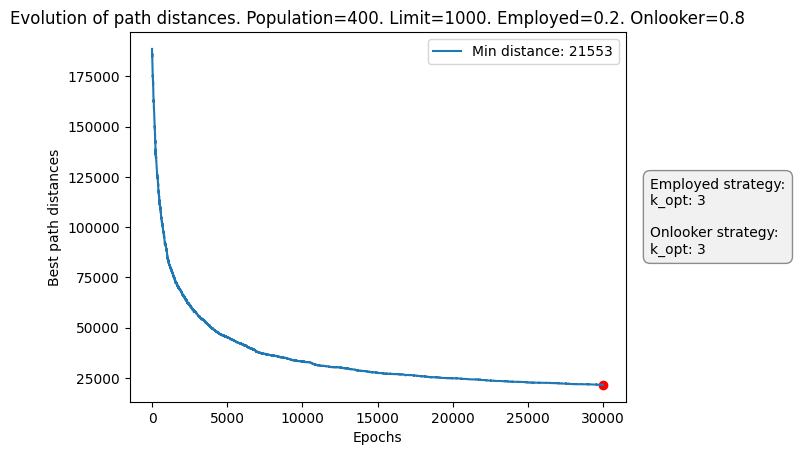

In [16]:
title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'


history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)

Iterations 0-1999: Improvement of 121546.00 units of distance (64.45%)
Iterations 2000-3999: Improvement of 17282.00 units of distance (25.77%)
Iterations 4000-5999: Improvement of 7949.00 units of distance (15.97%)
Iterations 6000-7999: Improvement of 5602.00 units of distance (13.39%)
Iterations 8000-9999: Improvement of 3024.00 units of distance (8.35%)
Iterations 10000-11999: Improvement of 2749.00 units of distance (8.28%)
Iterations 12000-13999: Improvement of 1949.00 units of distance (6.40%)
Iterations 14000-15999: Improvement of 1480.00 units of distance (5.19%)
Iterations 16000-17999: Improvement of 1204.00 units of distance (4.46%)
Iterations 18000-19999: Improvement of 984.00 units of distance (3.81%)
Iterations 20000-21999: Improvement of 827.00 units of distance (3.33%)
Iterations 22000-23999: Improvement of 861.00 units of distance (3.59%)
Iterations 24000-25999: Improvement of 548.00 units of distance (2.37%)
Iterations 26000-27999: Improvement of 591.00 units of distan

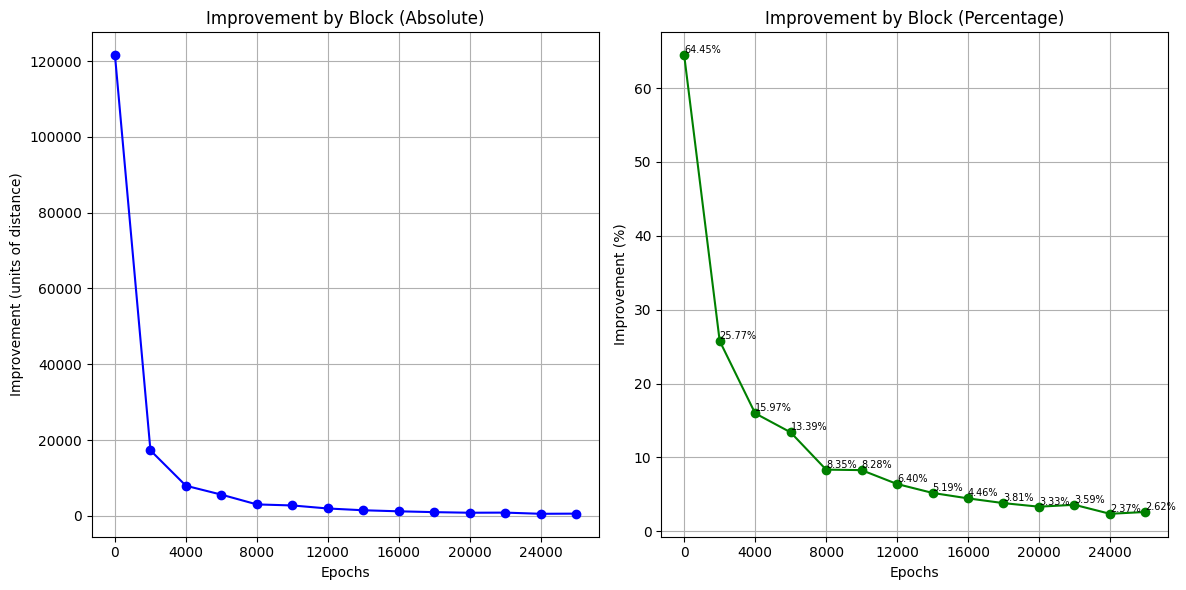

In [18]:
info_training(2000, paths_distances)

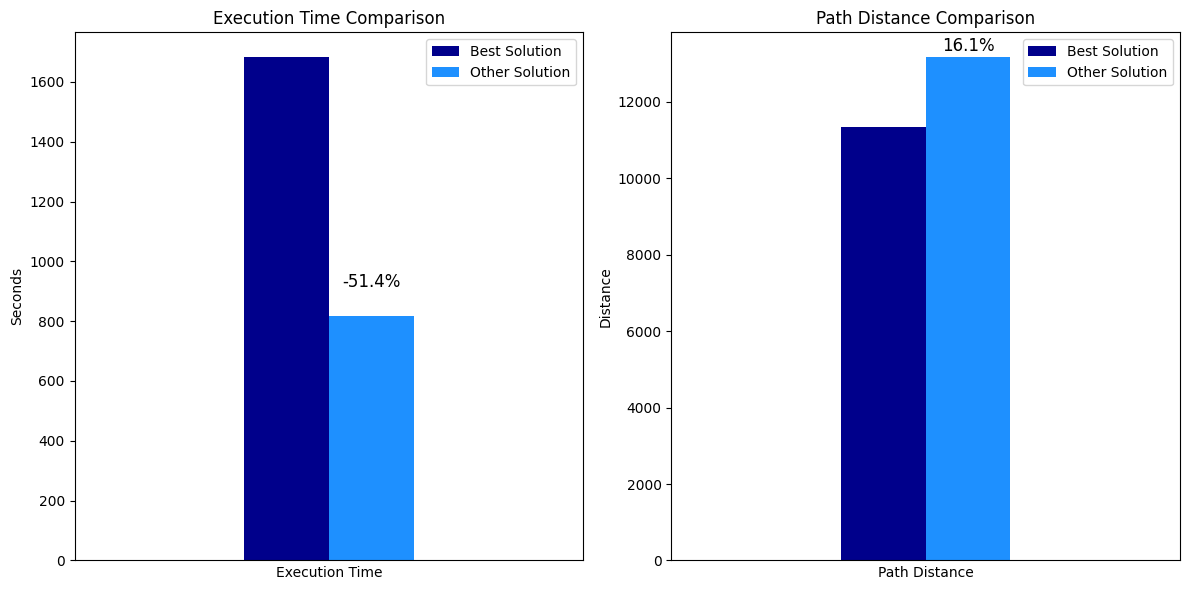

In [16]:
best_solution = [1681.68, 11340]
other_solution = [execution_time, final_best_path_distance]
plot_comparison(best_solution, other_solution)

## Find best hyper parameters

In [23]:
ini_end_city = 0

populations = np.arange(25, 100, step=25)
employed_porcentaje = 0.2
onlooker_percentaje = 0.8
limit = 2000
num_epochs = np.arange(10000, 60000, step=10000)

employed_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
onlooker_mutation_strategy = 'k_opt'    # swap, insertion, k_opt
num_k = np.arange(4, 9)

num_experiments = len(populations) * len(num_epochs) * len(num_k)
print(f"Number of experiments: {num_experiments}")

Number of experiments: 75


In [ ]:
for population in populations:
    for epochs in num_epochs:
        for k_employed in num_k:
            k_onlooker = k_employed

            ABC = ArtificialBeeColony_TSP.ArtificialBeeColonyOptimizer(ini_end_city, population, employed_porcentaje, limit, epochs, distance_matrix, 
                                                           employed_mutation_strategy, onlooker_mutation_strategy, k_employed, k_onlooker)

            execution_time, paths_distances, final_best_path, final_best_path_distance = ABC.fit()
            
            title = f'Evolution of path distances. Population={population}. Limit={limit}. Employed={employed_porcentaje}. Onlooker={onlooker_percentaje}'
            history_best_paths_distances(paths_distances, employed_mutation_strategy + ": " + str(k_employed), onlooker_mutation_strategy+ ": " + str(k_employed), title=title)

            info_training(2000, paths_distances)

            best_solution = [1681.68, 11340]
            other_solution = [execution_time, final_best_path_distance]
            plot_comparison(best_solution, other_solution)

## References

Karaboğa, D. (2005). *An idea based on honey bee swarm for numerical optimization*. Technical Report-TR06, Erciyes University, Engineering Faculty, Computer Engineering Department.